#PokeScraper

###Author: Syed (Sadat) Nazrul

Hello everyone! I hope you are all Pokemon fans. If not, I am sure you will still enjoy this tutorial (though I recommend you try Pokemon too....)

On this tutorial, we will cover the basics of web scraping, data frames, plotting. If you are patient, I will throw in a Pokedex GUI to the mix too!

Starting off, we will try scraping the online Pokemon Database (http://pokemondb.net/pokedex/all).

<img src="files/static/PokemonDatabase.png">

First off, we will import all the libraries needed to run our codes

In [1]:
import requests, six
import lxml.html as lh
from itertools import cycle, islice
from matplotlib import colors
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

###Web Scraping

Next, we initialize the url we wish to scrape.

In [2]:
url='http://pokemondb.net/pokedex/all'

Before moving further, we need to check how the web page is structured. To do this, we inspect by righ-clicking on any element on the table and clicking 'Inspect element'.

Based on the HTML codes, the data are stored in after <tr...

<img src="files/static/inspectElement.png">

First, we will get the url using Python's requests library. 

After that, we store the contents of the page under doc.

Using doc, we can collect all data that are under <tr... as tr_elements.

Just to make sure we collected information only from the table, we will check the size of the first 12 rows.

In [3]:
#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of the site's HTML code
tr_elements = doc.xpath('//tr')

#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

Good news. All the rows are of the same length of 10. 

This means all the data collected on tr_elements are from the table.

Next, let's parse the first row as our header.

In [4]:
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print '%d:"%s"'%(i,name)
    col.append((name,[]))

1:"#"
2:"Name"
3:"Type"
4:"Total"
5:"HP"
6:"Attack"
7:"Defense"
8:"Sp. Atk"
9:"Sp. Def"
10:"Speed"


Each header is appended to a tuple along with an empty list.

Let's populate these empty lists with the corresponding data!

In [5]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=10:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Just to be sure, let's check the length of each column. Ideally, they should all be the same.

In [6]:
[len(C) for (title,C) in col]

[800, 800, 800, 800, 800, 800, 800, 800, 800, 800]

Perfect! Now we cna construct our Data Frame using Pandas.

In [7]:
Dict={title:column for (title,column) in col}
import pandas as pd
df=pd.DataFrame(Dict)

In [8]:
df.head()

,#,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
0,001,49,49,45,Bulbasaur,65,65,45,318,GrassPoison
1,002,62,63,60,Ivysaur,80,80,60,405,GrassPoison
2,003,82,83,80,Venusaur,100,100,80,525,GrassPoison
3,003,100,123,80,VenusaurMega Venusaur,122,120,80,625,GrassPoison
4,004,52,43,39,Charmander,60,50,65,309,Fire


###Cleaning Data

We have successfully created a Data Frame. The problem is that the Name and Type section are disorganized. We wish to reformat both.

In [9]:
def str_bracket(word):
    '''Add brackets around second term'''
    list = [x for x in word]
    for char_ind in range(1, len(list)):
        if list[char_ind].isupper():
            list[char_ind] = ' ' + list[char_ind]
    fin_list = ''.join(list).split(' ')
    length = len(fin_list)
    if length>1:
        fin_list.insert(1,'(')
        fin_list.append(')')
    return ' '.join(fin_list)

    
def str_break(word):
    '''Break strings at upper case'''
    list = [x for x in word]
    for char_ind in range(1, len(list)):
        if list[char_ind].isupper():
            list[char_ind] = ' ' + list[char_ind]
    fin_list = ''.join(list).split(' ')
    return fin_list

In [10]:
word = 'ILovePokemon'
print str_bracket(word)
print str_break(word)

I ( Love Pokemon )
['I', 'Love', 'Pokemon']


We have both our functions (prepared AND tested)! 

Now let's apply them to our Data Frame.

In [11]:
df['Name']=df['Name'].apply(str_bracket)
df['Type']=df['Type'].apply(str_break)
df.head()

,#,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
0,001,49,49,45,Bulbasaur,65,65,45,318,"[Grass, Poison]"
1,002,62,63,60,Ivysaur,80,80,60,405,"[Grass, Poison]"
2,003,82,83,80,Venusaur,100,100,80,525,"[Grass, Poison]"
3,003,100,123,80,Venusaur ( Mega Venusaur ),122,120,80,625,"[Grass, Poison]"
4,004,52,43,39,Charmander,60,50,65,309,[Fire]


###Storing Data

Now that we have a clean Data Frame, we should back it up.

For this tutorialm we will use a JSON file.

In [12]:
df.to_json('PokemonData.json')

Let's see if we have properly backed up our data by opening the JSON file.

In [13]:
df = pd.read_json('PokemonData.json')
df=df.set_index(['#'])
df.head()

,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
#,,,,,,,,,
1,49,49,45,Bulbasaur,65,65,45,318,"[Grass, Poison]"
2,62,63,60,Ivysaur,80,80,60,405,"[Grass, Poison]"
8,63,80,59,Wartortle,65,80,58,405,[Water]
93,50,45,45,Haunter,115,55,95,405,"[Ghost, Poison]"
94,65,60,60,Gengar,130,75,110,500,"[Ghost, Poison]"


CONGRATULATIONS! You have successfully backup your data!

###Statistical Analysis

Now that we have a clean Data Frame, let's do some analysis. We wish to find the best (and worst) Pokemon for each stat.

In [14]:
def max_stats(df, col_list):
    '''Get Pokemon highest value of the column in the Data Frame'''
    message = ''
    for col in col_list:
        stat = df[col].max()
        name = df[df[col]==df[col].max()]['Name'].values[0]
        message += name+' has the greatest '+col+' of '+str(stat)+'.\n'
    return message

def min_stats(df, col_list):
    '''Get Pokemon lowest value of the column in the Data Frame'''
    message = ''
    for col in col_list:
        stat = df[col].max()
        name = df[df[col]==df[col].min()]['Name'].values[0]
        message += name+' has the worst '+col+' of '+str(stat)+'.\n'
    return message

In [15]:
stats=['Attack', 'Defense','HP', 'Sp. Atk','Sp. Def','Speed','Total']

print max_stats(df, stats)

print min_stats(df, stats)

Mewtwo ( Mega  Mewtwo  X ) has the greatest Attack of 190.
Steelix ( Mega  Steelix ) has the greatest Defense of 230.
Blissey has the greatest HP of 255.
Mewtwo ( Mega  Mewtwo  Y ) has the greatest Sp. Atk of 194.
Shuckle has the greatest Sp. Def of 230.
Deoxys ( Speed  Forme ) has the greatest Speed of 180.
Mewtwo ( Mega  Mewtwo  X ) has the greatest Total of 780.

Chansey has the worst Attack of 190.
Chansey has the worst Defense of 230.
Shedinja has the worst HP of 255.
Shuckle has the worst Sp. Atk of 194.
Caterpie has the worst Sp. Def of 230.
Shuckle has the worst Speed of 180.
Sunkern has the worst Total of 780.



As usual, Mewtwo takes the lead for multiple categories!

Next up, let's see if there is a statistical correlation between any of these stats. 

To do this, we will use a scatter matrix.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4039012f90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4036f96090>]], dtype=object)

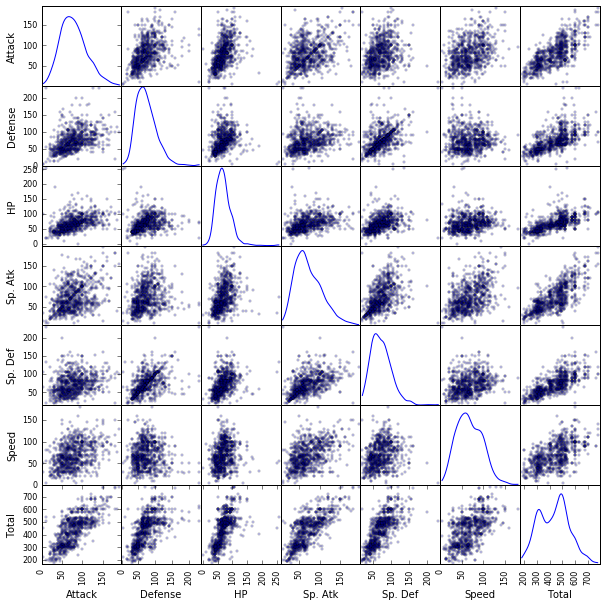

In [16]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df[stats], alpha=0.2, figsize=(10, 10), diagonal='kde')

It's too much information at this point. Also, Total is positively correlated with everything and hence can be taken out of the matrix.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4028e78850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f40228c7310>]], dtype=object)

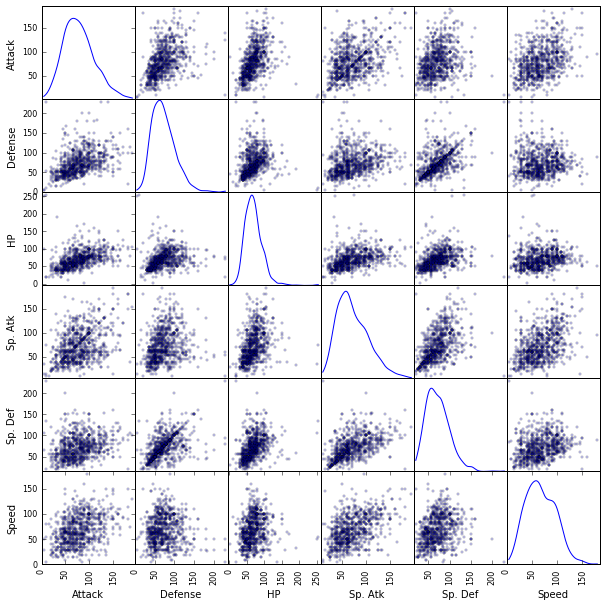

In [17]:
#'Total' is the last element of stats and hence taken out from the scatter matrix
scatter_matrix(df[stats[:-1]], alpha=0.2, figsize=(10, 10), diagonal='kde')

There seem to be some positive correlation between Defense and Special Defense.

Other stats have some correlation too but the $R^2$ values are too low.

Now that we have seen the information on abilities, let's dig deeper!

For out next analysis, we will the effect of Pokemon type on abilities.

In [18]:
#Creating new Data Frame where the Type values are separated from the list
newDict={}
stats_col=["#","Name","Total","HP","Attack","Defense","Sp. Atk","Sp. Def","Speed"]

#Collecting the list of Type for each Pokemon
Dict['Type']=df['Type'].values

#Creating an empty list for each key (column)
for col in stats_col:
    newDict[col]=[]
    newDict['Type']=[]

#Populating each the dictionary value (empty list) with data 
for row in range(len(Dict['#'])):
    for t in Dict['Type'][row]:
        for col in stats_col:
            #Append all columns except Type to the new dictionary
            newDict[col].append(Dict[col][row])
        #Appending the Type separately for each Pokemon  in the new dictionary
        newDict['Type'].append(t)
        
#Convert dictionary to a Data Frame
new_df = pd.DataFrame(newDict)

In [19]:
new_df.head()

,#,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
0,001,49,49,45,Bulbasaur,65,65,45,318,Grass
1,001,49,49,45,Bulbasaur,65,65,45,318,Poison
2,002,62,63,60,Ivysaur,80,80,60,405,Grass
3,002,62,63,60,Ivysaur,80,80,60,405,Poison
4,003,82,83,80,Venusaur,100,100,80,525,Water


Now that we have a new Data Frame restructured based on Type, let's see the unique Pokemon types.

In [20]:
types=new_df['Type'].unique()
print types

[u'Grass' u'Poison' u'Water' u'Ghost' u'Rock' u'Ground' u'Psychic'
 u'Electric' u'Fighting' u'Normal' u'Bug' u'Fairy' u'Flying' u'Ice' u'Fire'
 u'Dark' u'Dragon' u'Steel']


In [21]:
#Colours to cycle through when plotting the hbar graph
my_colors = list(six.iteritems(colors.cnames))
my_colors = list(islice(cycle(my_colors), None, len(new_df)))

def barh_stats():
    '''Plot hbar of mean and std. of each attribute of Pokemon Type'''
    i=0
    plt.figure(figsize=(15,5))
    for t in types:
        i+=1
        plt.suptitle('Statistics', fontsize=15)
        plt.subplot(121)
        plt.title('Mean')
        new_df[new_df['Type']==t].mean().plot(kind='barh', color=my_colors[i])
        plt.subplot(122)
        plt.title('Standard Deviation')
        new_df[new_df['Type']==t].std().plot(kind='barh', color=my_colors[i])
    plt.legend(types,bbox_to_anchor=(1.3, 1.1))

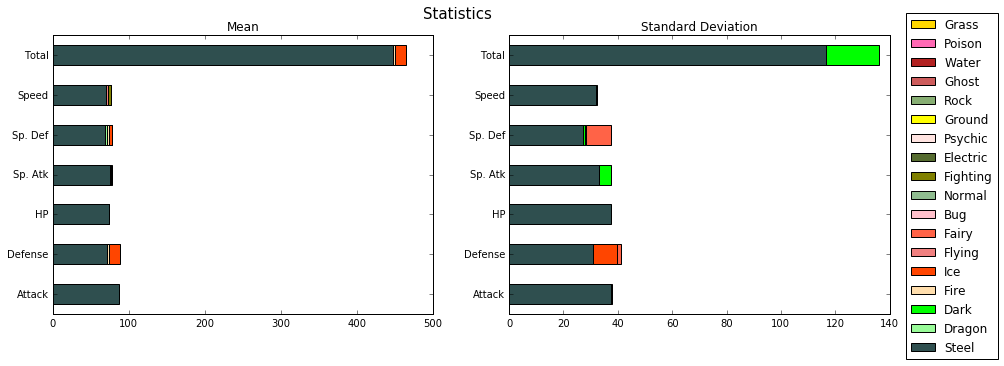

In [22]:
barh_stats()

Based on the graph, we can see that Ice types are better on average based on Total and Defense. 

Dark Types tend to have the grated variation in strength based on Total  and Sp. Attack while the greatest variation for Defense is among Ice types.

###GUI (aka PokeDex)

Now for the fun bit. We will try building a PokeDex. 

For this we will use the <b>PokemonData.json</b> file we have created before and look at the data using a Python GUI.

In [ ]:
import pandas as pd
import sys
from PyQt4 import QtGui, QtCore

class PokeDex(QtGui.QWidget):
    
    def __init__(self):
        super(PokeDex, self).__init__()
        
        self.initUI()
        
    def initUI(self):
        '''Initial UI'''
        
        #Grid Layout
        self.grid = QtGui.QGridLayout()
        self.setLayout(self.grid)
        
        #Parse JSON for DataFrame
        self.df = pd.read_json('PokemonData.json')
        self.df = self.df.set_index(['#'])
        
        #Drop Down
        self.dropdown = QtGui.QComboBox(self)
        self.names = self.df['Name'].values
        self.dropdown.addItems(self.names)
        self.grid.addWidget(self.dropdown, 0,0,1,1)
        
        #Name
        self.label = QtGui.QLabel('self')
        self.label.setAlignment(QtCore.Qt.AlignCenter)
        self.label.setText('\nName:\n\nType:\n\nHP:\n\nAttack\n\nSp. Attack\n\n Defense:\n\nSp. Defense:\n\nSpeed:\n\nTotal:')
        self.label.setAlignment(QtCore.Qt.AlignLeft)
        self.grid.addWidget(self.label, 1,0,1,1)

        #Search Button
        self.btn = QtGui.QPushButton('Search', self)
        self.btn.clicked.connect(self.runSearch)      
        self.grid.addWidget(self.btn, 0,1,1,1)
        
        #Customize Widgets
        self.resize(500, 250)
        self.center()
        self.setWindowTitle('PokeDex')    
        self.show()
        
    def runSearch(self):
        '''Event for run button'''
        
        #Parse value
        index = self.dropdown.currentIndex()
        val= self.names[index]
        cond = self.df['Name']== val
        
        #Set values
        name = 'Name:\t\t\t'+val+'\n\n'
        ty = 'Type:\t\t\t'+ ', '.join(self.df[cond]['Type'].values[0])+'\n\n'
        hp = 'HP:\t\t\t'+ str(self.df[cond]['HP'].values[0])+'\n\n'
        atk = 'Attack:\t\t\t'+str(self.df[cond]['Attack'].values[0])+'\n\n'
        satk = 'Sp. Attack:\t\t'+str(self.df[cond]['Sp. Atk'].values[0])+'\n\n'
        deff = 'Defense:\t\t'+str(self.df[cond]['Defense'].values[0])+'\n\n'
        sdef = 'Sp. Defense:\t\t'+str(self.df[cond]['Sp. Def'].values[0])+'\n\n'
        speed = 'Speed:\t\t\t'+str(self.df[cond]['Speed'].values[0])+'\n\n'
        total = 'Total:\t\t\t'+str(self.df[cond]['Total'].values[0])+'\n\n'
        
        #Add text
        final = name+ty+hp+atk+satk+deff+sdef+speed+total
        self.label.setText(final)
        
    def center(self):
        '''Center Widget on screen'''
        qr = self.frameGeometry()
        cp = QtGui.QDesktopWidget().availableGeometry().center()
        qr.moveCenter(cp)
        self.move(qr.topLeft())
        
def main():
    app = QtGui.QApplication(sys.argv)
    app.aboutToQuit.connect(app.deleteLater)
    gui = PokeDex()
    sys.exit(app.exec_())


if __name__ == '__main__':
    main()

If your code works, your Pokedex should look something like this:

<img src="files/static/PokeDex.jpg">

###Congratulations!!!

You can now: 

-scrape unstructured data from a website

-clean data and organize it into a sturctured form

-backup your data

-analyze your data

-present results on a user-friendly GUI